<img src='oar_logos/top.png' align='right'>

## Welcome to Pandas Stock with Panels!

In [1]:
import oar_style; oar_style.style()

In [2]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
from future import standard_library
standard_library.install_aliases()
from future.builtins import (
         bytes, dict, int, list, object, range, str,
         ascii, chr, hex, input, next, oct, open,
         pow, round, super, filter, map, zip)

<hr/>
This runs more smoothly under Python 3.x. However whether you're running on Python 2 or Python 3, install [Python-Future](http://python-future.org/futurize.html):  

```bash
conda install future
```

# Table of Contents
* [Objectives](#Objectives)
* [Set-up](#Set-up)
* [Demo: Manipulating Tick Data](#Demo:-Manipulating-Tick-Data)
	* [Reading data](#Reading-data)
	* [Building the dataset for a single stock symbol](#Building-the-dataset-for-a-single-stock-symbol)
	* [Building a dataset for all stocks](#Building-a-dataset-for-all-stocks)
	* [The most traded stocks](#The-most-traded-stocks)
* [Demo: The Olympics, bets, and stochastic dominance](#Demo:-The-Olympics,-bets,-and-stochastic-dominance)
	* [Panel data](#Panel-data)

# Objectives

Learn to use pandas to:
* manipulate tick data
* read data
* build a dataset
* use panels

# Set-up

### Let's import some libraries

In [3]:
try:
    from urllib.request import urlretrieve
except ImportError:
    # we are in Python 2
    from urllib import urlretrieve
from zipfile import ZipFile
import os.path
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(plt.style.available)
plt.style.use('ggplot')
%matplotlib inline

import bokeh.charts, bokeh.io
bokeh.io.output_notebook()

['seaborn-darkgrid', 'grayscale', 'seaborn-talk', 'seaborn-dark-palette', 'dark_background', 'fivethirtyeight', 'classic', 'seaborn-poster', 'seaborn-ticks', 'seaborn-whitegrid', 'bmh', 'seaborn', 'seaborn-dark', 'seaborn-notebook', 'seaborn-white', 'seaborn-deep', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-muted', 'seaborn-paper', '_classic_test', 'seaborn-pastel', 'ggplot']


/Users/kcom/minic/envs/3.5/lib/python3.5/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


Loading BokehJS ...

# Demo: Manipulating Tick Data

We will work with data from [QuantQuote](https://quantquote.com/historical-stock-data).

- Dimensions: date, time, stock symbol
- Metrics: opening, high, low and closing prices, as well as trade volume
- Frequency: daily
- Dates: 1998 to 2015
- Scope: 500 stock symbols that constitute the S&P500 as of Dec 2015.

Let's get the data

## Reading data

In [4]:
if not os.path.exists('tmp'):
    os.mkdir('tmp')
def download(url):
    local_fname = os.path.join('tmp',url.split('/')[-1])
    if os.path.exists(local_fname):
        return local_fname
    else:
        urlretrieve(url, local_fname)
        return local_fname

data_url = 'http://quantquote.com/files/quantquote_daily_sp500_83986.zip'
metadata_url = 'https://quantquote.com/docs/QuantQuote_Minute.pdf'

# Download data
data_fname = download(data_url)

# Extract the data
with ZipFile(data_fname) as zf:
    zf.extractall(path='tmp')

# Download PDF with the metadata
metadata_fname = download(metadata_url)

For each one of the 500 stock symbols, we have a file. Here is a sample:

In [5]:
data_dir = os.path.join('tmp','quantquote_daily_sp500_83986', 'daily')
pprint(os.listdir(data_dir)[:10])

['table_dlph.csv',
 'table_cat.csv',
 'table_coh.csv',
 'table_mcd.csv',
 'table_ca.csv',
 'table_mwv.csv',
 'table_twc.csv',
 'table_lsi.csv',
 'table_life.csv',
 'table_pnr.csv']


From the downloaded PDF (see `metadata_fname`) we can obtain the field names (and their descriptions):

In [6]:
fieldnames = [
    'date',
    'time',
    'open',
    'high',
    'low',
    'close',
    'volume' 
]

## Building the dataset for a single stock symbol

We can now easily import the data of a single stock, for example, Apple (AAPL). We will drop the `time` field because it's useless.

First, let's get set to work with dataframes and matplotlib visualizations.

In [7]:
def import_data(symbol, fieldnames=fieldnames, set_index=True, add_symbol=False):
    data_path = os.path.join('tmp','quantquote_daily_sp500_83986',
                             'daily',
                             'table_' + symbol + '.csv')
    data = pd.read_csv(data_path,
                       names=fieldnames).drop('time', axis=1)
    data['date'] = pd.to_datetime(data.date, format='%Y%m%d')
    if set_index:
        data.set_index('date', inplace=True)
    if add_symbol:
        data['symbol'] = symbol
    return data

In [8]:
aapl = import_data('aapl')
print(aapl.info())
print(aapl.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3926 entries, 1998-01-02 to 2013-08-09
Data columns (total 5 columns):
open      3926 non-null float64
high      3926 non-null float64
low       3926 non-null float64
close     3926 non-null float64
volume    3926 non-null float64
dtypes: float64(5)
memory usage: 184.0 KB
None
              open         high          low        close        volume
count  3926.000000  3926.000000  3926.000000  3926.000000  3.926000e+03
mean    131.046735   132.547087   129.276820   130.936396  1.996621e+07
std     165.720993   167.175882   163.849101   165.519449  1.395386e+07
min       3.313970     3.950980     3.282360     3.890200  1.437792e+06
25%      10.879200    11.127125    10.645725    10.892600  1.067201e+07
50%      52.551700    53.052600    51.491650    52.308600  1.581984e+07
75%     184.108000   185.625500   180.998750   184.118500  2.529142e+07
max     685.808000   688.660000   683.287000   685.662000  2.339738e+08


We can quickly look at things like the closing prices:

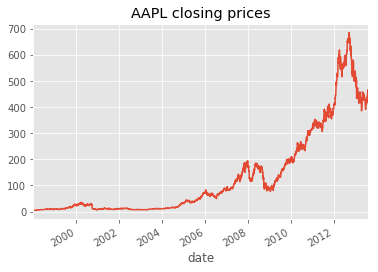

In [9]:
aapl.close.plot(title='AAPL closing prices')

In [10]:
p = bokeh.charts.Line(aapl.close.reset_index(), x='date', y='close')
bokeh.io.show(p)

This kind of plot where you have a lot of data points in the x-axis begs for interactivity: sometimes we want to inspect prices dates where something happened. Bokeh can help greatly here, allowing you to zoom in the dates you are interested in easily.

We can also look at the relative difference between open and close prices:

count    3926.000000
mean        0.000325
std         0.025235
min        -0.114119
25%        -0.013423
50%         0.000000
75%         0.012963
max         0.192220
dtype: float64


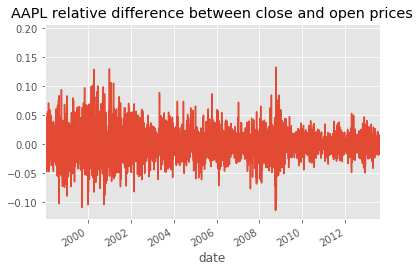

In [11]:
_df = (aapl.close - aapl.open) / aapl.open
print(_df.describe())
_df.plot(title='AAPL relative difference between close and open prices') 

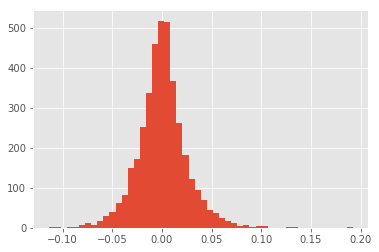

In [12]:
_df.hist(bins=50)

## Building a dataset for all stocks

First, you should check if the data is "too big" just by looking at its size. It's 35M compressed, so we will be fine loading it all in memory.

In [62]:
_data_dir = os.path.join('tmp','quantquote_daily_sp500_83986', 'daily')

def make_dataset(data_dir=_data_dir):      
    data_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    symbols = [os.path.splitext(f)[0].split('_')[1] for f in data_files]
    df_by_symbol = (import_data(s, set_index=False, add_symbol=True)
                    for s in symbols)
    df = pd.concat(df_by_symbol)
      
    # Encode categorical variables efficiently
    df['symbol'] = df.symbol.astype('category') 
    # Set an index and assert it is well behaved
    df = df.set_index(['symbol', 'date']).sort_index()
    assert df.index.is_unique and df.index.is_monotonic
    return df

%time df = make_dataset()

CPU times: user 10.3 s, sys: 1.29 s, total: 11.6 s
Wall time: 12.2 s


We can now access the data in various ways:

In [15]:
df.head()

open     high      low    close        volume
symbol date                                                        
a      1999-11-18  42.2076  46.3820  37.4581  39.1928  4.398181e+07
       1999-11-19  39.8329  39.8885  36.9293  37.6251  1.139020e+07
       1999-11-22  38.3208  40.0091  37.1613  39.9442  4.654716e+06
       1999-11-23  39.4247  40.4729  37.3375  37.5138  4.268903e+06
       1999-11-24  37.2262  38.9052  37.1056  38.0889  3.602367e+06

In [16]:
df.loc['aapl'].head()

,open,high,low,close,volume
date,,,,,
1998-01-02,3.31397,3.95098,3.28236,3.95098,24947201.10
1998-01-05,4.01177,4.02635,3.69325,3.89020,22344145.08
1998-01-06,3.87561,4.98432,3.58628,4.60502,63150252.55
1998-01-07,4.57341,4.68040,4.20871,4.24032,36978255.52
1998-01-08,4.24032,4.52965,4.11875,4.39107,27687622.95


Let's say now we want to visualize the closing prices for Microsoft (MSFT) and Apple (AAPL) stock:

symbol         aapl     msft
date                        
1998-01-02  3.95098  12.2332
1998-01-05  3.89020  12.1753
1998-01-06  4.60502  12.2510
1998-01-07  4.24032  12.0931
1998-01-08  4.39107  12.1753


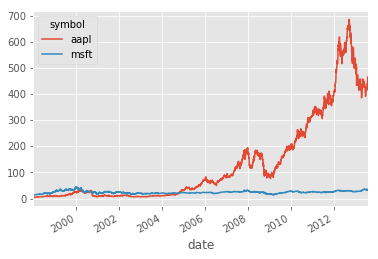

In [17]:
_symbols = ['aapl', 'msft']
_df = df.loc[_symbols].close.unstack('symbol')

print(_df.head())
_df.plot()

The main thing to remember about plotting with pandas is __the x-axis corresponds to the index and each column corresponds to a different series__.

Log-scale on the closing price might help clear things up here:

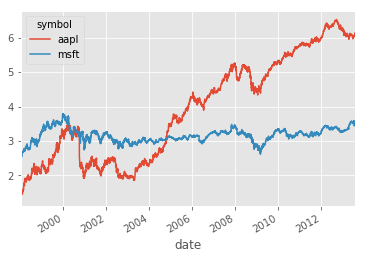

In [18]:
# one way of using log scale in the y-axis
np.log(_df).plot()

The plots handle missing data gracefully too:

symbol         aapl  goog     msft     yhoo
date                                       
1998-01-02  3.95098   NaN  12.2332  4.14437
1998-01-05  3.89020   NaN  12.1753  3.92563
1998-01-06  4.60502   NaN  12.2510  3.99250
1998-01-07  4.24032   NaN  12.0931  3.98813
1998-01-08  4.39107   NaN  12.1753  4.01562


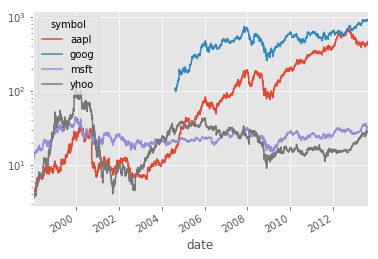

In [19]:
_symbols = ['aapl', 'msft', 'goog', 'yhoo']
_df = df.loc[_symbols].close.unstack('symbol')

print(_df.head())
_df.plot(logy=True) # another way of using log scale in the y-axis

Notice how the legend covers part of the plot. Pandas plots are just matplotlib plots and thus you can [modify their legend](http://matplotlib.org/users/legend_guide.html) the same way:

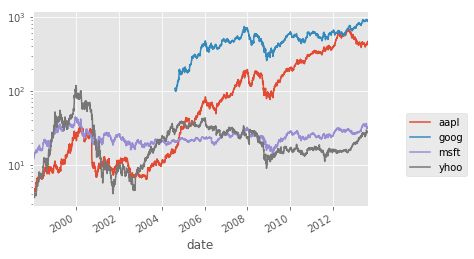

In [20]:
# Sets the upper-left corner of the legend box at position bbox_to_anchor
# bbox_to_anchor=(0.5,0.5) would be the center of the plot

_df.plot(logy=True).legend(bbox_to_anchor=(1.1, 0.5), loc='upper left')

# exercise: restrict the plot to the period after the first iPhone release (June 2007)

We can also plot one stock against another:

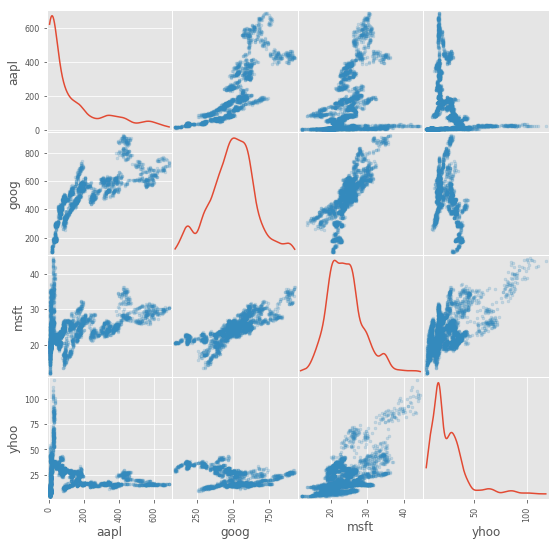

In [21]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(_df, alpha=0.2, figsize=(9, 9), diagonal='kde');

You may also want to know how much you would have made over time from 1 dollar invested on each stock on Jan 1st 2006:

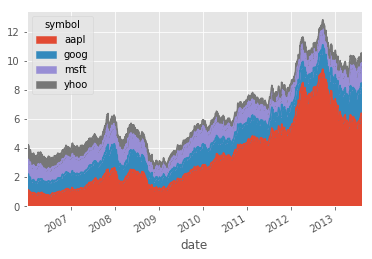

In [22]:
_symbols = ['aapl', 'msft', 'goog', 'yhoo']
_df = df.loc[_symbols].close.unstack('symbol').loc['2006':]


_df.div(_df.iloc[0]).plot(kind='area')

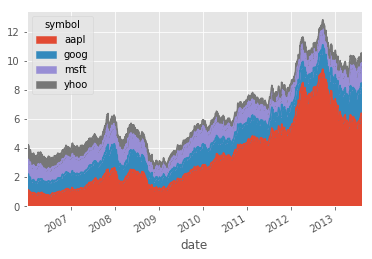

In [23]:
# Only on pandas 0.17+

_df.div(_df.iloc[0]).plot.area()

## The most traded stocks

We could want to restrict attention to the most traded stocks. To find 20 most traded stocks:

In [24]:
most_traded_symb = (
    df.groupby(level='symbol')
      .sum()
      .sort_values(by='volume', ascending=False)
      .index
      .tolist()
)

most_traded_symb[:20]

['bac',
 'msft',
 'intc',
 'csco',
 'ge',
 'mo',
 'orcl',
 'pfe',
 'f',
 'amat',
 'dell',
 'yhoo',
 'wfc',
 'qcom',
 'jpm',
 's',
 'aapl',
 't',
 'emc',
 'gild']

Why isn't Google there? Let's see where Google is in the list:

In [25]:
most_traded_symb.index('goog')

219

Wow, not even close to top 20 most traded. I wonder why.

In [26]:
# exercise: select different combinations of stock symbols and dates
# See http://pandas.pydata.org/pandas-docs/stable/advanced.html#using-slicers
idx = pd.IndexSlice

top20 = df.loc[idx[most_traded_symb[:20],:], ['open', 'close']]

top20.head()

open    close
symbol date                        
aapl   1998-01-02  3.31397  3.95098
       1998-01-05  4.01177  3.89020
       1998-01-06  3.87561  4.60502
       1998-01-07  4.57341  4.24032
       1998-01-08  4.24032  4.39107

In [27]:
top20.close.unstack('symbol').head()

symbol,aapl,amat,bac,csco,dell,emc,f,ge,gild,intc,jpm,mo,msft,orcl,pfe,qcom,s,t,wfc,yhoo
date,,,,,,,,,,,,,,,,,,,,
1998-01-02,3.95098,6.63895,18.7499,9.17855,10.4144,7.11535,11.9377,16.0195,1.19531,13.9559,23.2635,4.65115,12.2332,3.67267,15.7951,2.71898,19.7192,18.9224,12.7300,4.14437
1998-01-05,3.89020,7.07411,19.2905,9.15009,10.7330,7.06904,11.9377,16.3447,1.21500,14.3037,23.7137,4.70871,12.1753,3.74312,16.7389,2.75519,19.5695,18.4174,12.6463,3.92563
1998-01-06,4.60502,6.69897,19.0403,9.04101,10.7488,6.85696,11.7204,16.1127,1.22281,14.0635,22.6569,4.71590,12.2510,3.64225,16.2146,2.72895,20.1242,18.3063,12.5025,3.99250
1998-01-07,4.24032,6.31097,19.1175,8.76436,10.4752,6.70340,11.6292,16.2211,1.21500,13.9559,22.7224,4.81150,12.0931,3.37169,16.3467,2.50906,19.8247,18.4532,12.2717,3.98813
1998-01-08,4.39107,6.28310,18.8858,8.87344,10.4898,6.59614,11.1184,16.0997,1.23438,14.2672,22.0481,4.77963,12.1753,3.25161,16.3341,2.53530,19.1883,18.3566,12.5025,4.01562


We may want to exclude AAPL from a visualizations of returns over time on a dollar invested:

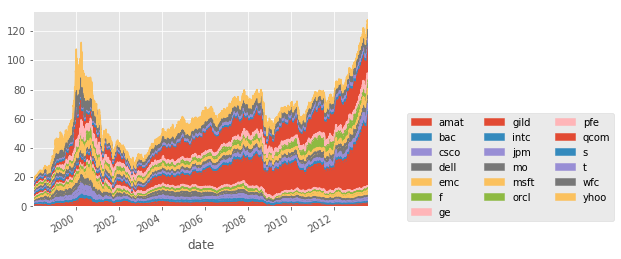

In [28]:
_df0 = top20.drop('aapl').unstack(level='symbol')
_df0.div(_df0.iloc[0]).close.plot.area().legend(bbox_to_anchor=(1.1, 0.5), loc='upper left', ncol=3)

In [29]:
# Exercise: which days of the week see the most trade? What about days of the month?

# Demo: The Olympics, bets, and stochastic dominance

We will now look into a visual way of choosing among multiple alternatives that give you a random return.

Before that, a short detour into athletics: in the 2012 summer olympics, these were the number of gold, silver and bronze medals for the US, China, Russia and Great Britain, respectively:

- US: 46,29,29
- China: 38,27,22
- Russia: 24,25,33
- Great Britain: 29, 17,19

How do these olympic teams compare? Who is better: Great Britain or Russia? Here is a visual answer:

In [30]:
medals = {'US': [46,29,29],
          'China': [38,27,22],
          'Russia': [24,25,33],
          'Great Britain': [29, 17,19],
          'medals': ['gold', 'silver', 'bronze']}

summer_olymp = pd.DataFrame(medals).set_index('medals')
summer_olymp

,China,Great Britain,Russia,US
medals,,,,
gold,38,29,24,46
silver,27,17,25,29
bronze,22,19,33,29


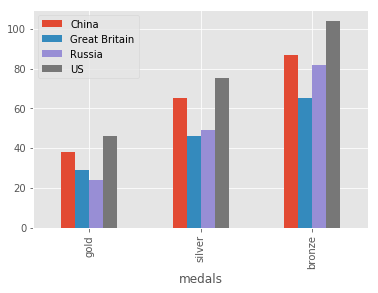

In [31]:
# Note that to interpret the index/x-axis, you need to know we are doing a cumulative sum
# It's easy to do it this way, but it can confuse your audience. Be careful.

summer_olymp.cumsum().plot.bar()

It follows from above that, unanmbiguously, US > China > {Russia, Great Britan}. However, whether Russia beats Great Britain or vice-versa depends on the relative weights of each type of medal.

Note that Great Britan has more gold medals than Russia, but Russia has more medals than Great Britan when we count gold and silver, or when we count all three types of medals.

The following plot is another way of visualizing the same information.

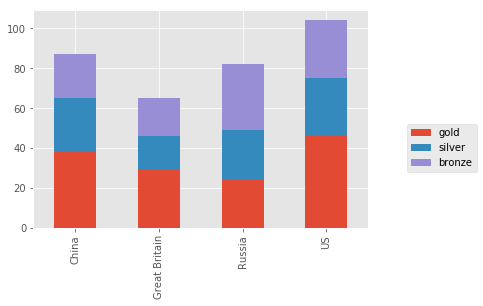

In [32]:
summer_olymp.transpose().plot.bar(stacked=True).legend(bbox_to_anchor=(1.1, 0.5), 
                                                       loc='upper left', ncol=1)

We can use similar ideas when making bets, choosing models, etc. as long as the returns from our choice can be quantified in a probability distribution.

For simplicity, imagine stock returns are independent, and that you need to choose one stock to "bet on". Betting on a stock means that you will buy 1 dollar of it when the market opens, and sell the stock you bought in the end of the day. Again, for simplicity, restrict attention to the stocks ['ge', 'nflx', 'yhoo'].

One way to proceed could be as follows. We compare the empirical cumulative distribution function (ECDF) of each alternative: the alternative with the "lowest" ECDF (if there is one), is the best alternative. That is because that "lowest" ECDF unambiguously puts more mass on higher-value outcomes. In particular, if we ranked the alternatives by the mean, median, quartiles, etc., all these measures would agree that the alternative with the lowest ECDF would be the best. In that case, we say this lowest ECDF stochastically dominates all other distributions in a first-order sense.

If there is no uniformly lowest ECDF, then we need to analyze the graph and see where various ECDFs cross each other to make a judgement call.

You may want to look up the definition of [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) and [first-order stochastic dominance](https://en.wikipedia.org/wiki/Stochastic_dominance#First-order_stochastic_dominance).

In [33]:
spread = ((df.close - df.open) / df.open).loc[['ge', 'nflx', 'yhoo']]

In [34]:
def plot_cdfs(spread):
    binned = spread.reset_index().groupby(['symbol', 0]).count()
    binned.index.names = ['symbol', 'bin']
    numerator = binned.unstack(level='symbol').cumsum()
    denominator = binned.unstack(level='symbol').sum()
    return numerator.div(denominator).plot()

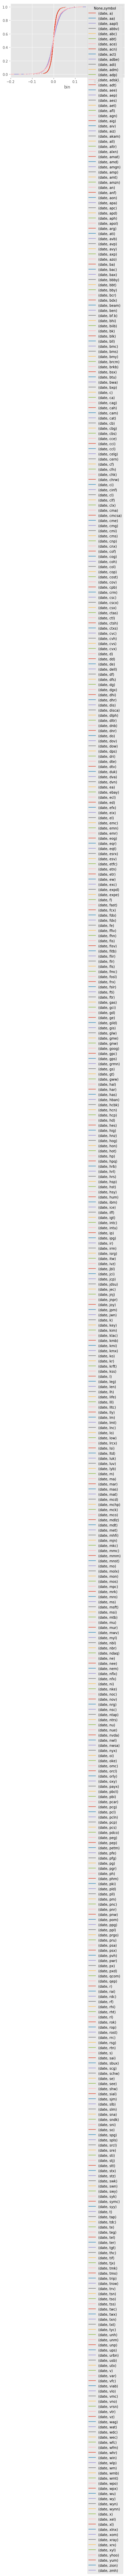

In [35]:
plot_cdfs(spread)

As you can see, there is no clear winner: the options with good returns are also the options with high costs.

What if you could somehow guess if the stock will go up or down in that day. In that case, let's say a bet means you can also _sell_ 1 dollar's worth of the stock in the beginning of the day, then buy back that same amount of stock at the end of the day.

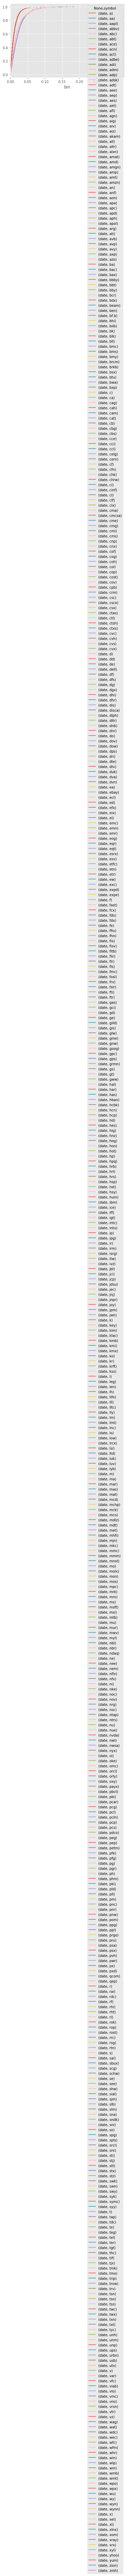

In [36]:
plot_cdfs(np.abs(spread))

And in this case Netflix looks like the winner, beating Yahoo by a narrow margin.

## Panel data

In [37]:
pan = df.to_panel()
pan

<class 'pandas.core.panel.Panel'>
Dimensions: 5 (items) x 500 (major_axis) x 3926 (minor_axis)
Items axis: open to volume
Major_axis axis: a to zmh
Minor_axis axis: 1998-01-02 00:00:00 to 2013-08-09 00:00:00

In [38]:
# Note that dates go in the columns, for some reason

pan.loc['close'].head()

date,1998-01-02 00:00:00,1998-01-05 00:00:00,1998-01-06 00:00:00,1998-01-07 00:00:00,1998-01-08 00:00:00,1998-01-09 00:00:00,1998-01-12 00:00:00,1998-01-13 00:00:00,1998-01-14 00:00:00,1998-01-15 00:00:00,...,2013-07-29 00:00:00,2013-07-30 00:00:00,2013-07-31 00:00:00,2013-08-01 00:00:00,2013-08-02 00:00:00,2013-08-05 00:00:00,2013-08-06 00:00:00,2013-08-07 00:00:00,2013-08-08 00:00:00,2013-08-09 00:00:00
symbol,,,,,,,,,,,,,,,,,,,,,
a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.30000,44.88000,44.71000,46.04000,46.36000,45.87000,46.050,46.300,45.86,46.24
aa,13.35110,13.58530,13.28170,13.30420,12.75330,12.44970,12.39160,12.37860,12.39160,12.34480,...,8.00951,8.01947,7.91985,7.91985,7.93977,7.97962,7.880,7.780,7.91,8.20
aapl,3.95098,3.89020,4.60502,4.24032,4.39107,4.43726,4.46886,4.76306,4.78738,4.66581,...,444.92200,450.60500,449.50200,453.42600,459.47600,466.14200,462.307,461.791,461.06,454.37
abbv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.97000,44.74000,45.43000,45.26000,45.28000,44.67000,44.830,44.590,45.05,44.71
abc,6.50799,6.40419,6.28477,6.34839,6.38299,6.18767,5.99905,6.08945,6.22227,6.39638,...,58.41000,58.25000,58.25000,58.81000,58.46000,59.01000,58.640,58.770,59.62,59.50


In [39]:
# This fixes it

pan.loc['close'].transpose().head()

symbol,a,aa,aapl,abbv,abc,abt,ace,acn,act,adbe,...,xl,xlnx,xom,xray,xrx,xyl,yhoo,yum,zion,zmh
date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,NaN,13.3511,3.95098,NaN,6.50799,10.3555,22.9865,NaN,32.06,4.99041,...,40.6169,7.96400,21.6592,9.04339,30.5852,NaN,4.14437,6.14229,36.2098,NaN
1998-01-05,NaN,13.5853,3.89020,NaN,6.40419,10.4031,22.8365,NaN,33.63,5.05201,...,40.8146,7.80886,21.4182,8.77893,31.0476,NaN,3.92563,5.99731,36.9102,NaN
1998-01-06,NaN,13.2817,4.60502,NaN,6.28477,10.2311,23.0180,NaN,33.44,5.23685,...,40.6923,7.75715,20.6111,8.75765,30.7898,NaN,3.99250,5.75640,36.5122,NaN
1998-01-07,NaN,13.3042,4.24032,NaN,6.34839,10.2880,23.1389,NaN,32.69,5.15182,...,39.9766,7.42204,21.2435,8.70293,29.7423,NaN,3.98813,5.75640,35.4618,NaN
1998-01-08,NaN,12.7533,4.39107,NaN,6.38299,10.4507,22.7446,NaN,33.38,5.20604,...,39.4021,7.45928,20.8068,8.64518,29.1286,NaN,4.01562,5.53041,32.6286,NaN


Another way to build a panel:

In [40]:
dd = {sym: df.loc[sym] for sym in most_traded_symb[:20]}
panel = pd.Panel(dd)

In [41]:
panel.loc['yhoo'].head()

# Note that this time the dates came correctly in the rows

,open,high,low,close,volume
date,,,,,
1998-01-02,4.32812,4.34375,4.06250,4.14437,17153600.0
1998-01-05,4.02375,4.08625,3.91438,3.92563,25585600.0
1998-01-06,3.85938,4.07062,3.82812,3.99250,27243200.0
1998-01-07,3.92188,4.05500,3.91438,3.98813,15307200.0
1998-01-08,4.00000,4.12313,3.92188,4.01562,21256000.0


In [42]:
panel.loc[:,'1998-01-02']

,aapl,amat,bac,csco,dell,emc,f,ge,gild,intc,jpm,mo,msft,orcl,pfe,qcom,s,t,wfc,yhoo
open,3.313970e+00,6.484600e+00,1.884560e+01,8.952480e+00,1.031470e+01,6.674140e+00,1.201410e+01,1.589590e+01,1.195310e+00,1.358310e+01,2.296120e+01,4.664510e+00,1.210530e+01,3.583020e+00,1.582240e+01,2.689590e+00,1.986900e+01,1.868510e+01,1.279350e+01,4.328120e+00
high,3.950980e+00,6.645380e+00,1.896300e+01,9.229140e+00,1.045940e+01,7.161660e+00,1.206100e+01,1.601950e+01,1.207190e+00,1.395590e+01,2.326350e+01,4.702540e+00,1.227990e+01,3.752720e+00,1.582240e+01,2.778280e+00,1.988940e+01,1.897040e+01,1.289720e+01,4.343750e+00
low,3.282360e+00,6.431010e+00,1.869120e+01,8.794400e+00,1.018570e+01,6.674140e+00,1.187590e+01,1.572020e+01,1.171880e+00,1.354660e+01,2.273510e+01,4.644980e+00,1.209310e+01,3.542990e+00,1.552030e+01,2.683290e+00,1.948440e+01,1.862190e+01,1.270990e+01,4.062500e+00
close,3.950980e+00,6.638950e+00,1.874990e+01,9.178550e+00,1.041440e+01,7.115350e+00,1.193770e+01,1.601950e+01,1.195310e+00,1.395590e+01,2.326350e+01,4.651150e+00,1.223320e+01,3.672670e+00,1.579510e+01,2.718980e+00,1.971920e+01,1.892240e+01,1.273000e+01,4.144370e+00
volume,2.494720e+07,1.819823e+07,3.668616e+06,4.237089e+07,3.885274e+07,9.182809e+06,7.442033e+06,1.284872e+07,2.876800e+06,4.912078e+07,4.293872e+06,3.768832e+07,4.925718e+07,2.696706e+07,6.577349e+06,2.767731e+07,2.907102e+06,8.224924e+06,2.762274e+06,1.715360e+07


In [43]:
panel.loc[:,:,'close'].head()

,aapl,amat,bac,csco,dell,emc,f,ge,gild,intc,jpm,mo,msft,orcl,pfe,qcom,s,t,wfc,yhoo
date,,,,,,,,,,,,,,,,,,,,
1998-01-02,3.95098,6.63895,18.7499,9.17855,10.4144,7.11535,11.9377,16.0195,1.19531,13.9559,23.2635,4.65115,12.2332,3.67267,15.7951,2.71898,19.7192,18.9224,12.7300,4.14437
1998-01-05,3.89020,7.07411,19.2905,9.15009,10.7330,7.06904,11.9377,16.3447,1.21500,14.3037,23.7137,4.70871,12.1753,3.74312,16.7389,2.75519,19.5695,18.4174,12.6463,3.92563
1998-01-06,4.60502,6.69897,19.0403,9.04101,10.7488,6.85696,11.7204,16.1127,1.22281,14.0635,22.6569,4.71590,12.2510,3.64225,16.2146,2.72895,20.1242,18.3063,12.5025,3.99250
1998-01-07,4.24032,6.31097,19.1175,8.76436,10.4752,6.70340,11.6292,16.2211,1.21500,13.9559,22.7224,4.81150,12.0931,3.37169,16.3467,2.50906,19.8247,18.4532,12.2717,3.98813
1998-01-08,4.39107,6.28310,18.8858,8.87344,10.4898,6.59614,11.1184,16.0997,1.23438,14.2672,22.0481,4.77963,12.1753,3.25161,16.3341,2.53530,19.1883,18.3566,12.5025,4.01562


In [44]:
panel.apply(lambda x: x.mean(), axis='major_axis')

,aapl,amat,bac,csco,dell,emc,f,ge,gild,intc,jpm,mo,msft,orcl,pfe,qcom,s,t,wfc,yhoo
open,1.310467e+02,1.521490e+01,2.351986e+01,2.230400e+01,2.463181e+01,2.137610e+01,1.228487e+01,2.284817e+01,1.398599e+01,2.098537e+01,3.320697e+01,1.266997e+01,2.410218e+01,1.851415e+01,2.065323e+01,3.397611e+01,1.582439e+01,2.273048e+01,2.280122e+01,2.368404e+01
high,1.325471e+02,1.551963e+01,2.380884e+01,2.266644e+01,2.504683e+01,2.178556e+01,1.246526e+01,2.310348e+01,1.417629e+01,2.131429e+01,3.368407e+01,1.278021e+01,2.440039e+01,1.881961e+01,2.089012e+01,3.453913e+01,1.607494e+01,2.298542e+01,2.308924e+01,2.419511e+01
low,1.292768e+02,1.490201e+01,2.321553e+01,2.191616e+01,2.421580e+01,2.092872e+01,1.208637e+01,2.256416e+01,1.378817e+01,2.065451e+01,3.271626e+01,1.255863e+01,2.380404e+01,1.820517e+01,2.040168e+01,3.341242e+01,1.556180e+01,2.245879e+01,2.249846e+01,2.315532e+01
close,1.309364e+02,1.520518e+01,2.350629e+01,2.228896e+01,2.463741e+01,2.136777e+01,1.226875e+01,2.284024e+01,1.398583e+01,2.097465e+01,3.320656e+01,1.267018e+01,2.410165e+01,1.851167e+01,2.064956e+01,3.397988e+01,1.581697e+01,2.272408e+01,2.280156e+01,2.366345e+01
volume,1.996621e+07,2.836790e+07,7.297674e+07,5.647256e+07,2.595783e+07,1.878102e+07,3.305293e+07,4.345911e+07,1.864762e+07,6.684555e+07,2.251725e+07,4.069884e+07,7.238078e+07,3.996084e+07,3.444986e+07,2.332648e+07,2.171687e+07,1.935890e+07,2.334166e+07,2.432454e+07


In [45]:
df.loc['nflx'].head()

,open,high,low,close,volume
date,,,,,
2002-05-23,8.095,8.700,8.02,8.380,14101400.0
2002-05-24,8.500,8.575,8.38,8.475,1506800.0
2002-05-28,8.495,8.625,8.13,8.130,917000.0
2002-05-29,8.150,8.150,7.60,7.770,953200.0
2002-05-30,7.755,7.755,7.50,7.500,1422400.0


Panels are more compelling when we have 3 bona-fide dimensions. Here we have only two: symbol and date.

To see how natural panels can be, imagine some transactions happening a market for a given good. Every transaction is recorded as 

    (buyer, seller, timestamp, quantity, payment)
    
Let's generate some data quickly.

In [46]:
from itertools import product, islice
import random

In [47]:
def mkt_data_gen():
    buyer = random.choice(['buyer_' + str(i) for i in range(3)])
    seller = random.choice(['seller_' + str(j) for j in range(4)])
    timestamp = random.choice(pd.date_range('2015-01-01', '2015-01-05'))
    quantity = random.randint(1,101)
    payment = np.random.lognormal(6, 2)
    return timestamp, buyer, seller, quantity, payment

In [48]:
transactions = pd.DataFrame(
    sorted([mkt_data_gen() for __ in range(100)]),
    columns=['timestamp', 'buyer', 'seller', 'quantity', 'payment']
).groupby(['timestamp', 'buyer', 'seller']).sum()

This is the hierarchical dataframe that represents the data:

In [49]:
transactions.head(20)

quantity       payment
timestamp  buyer   seller                          
2015-01-01 buyer_0 seller_0       121   2963.082678
                   seller_1       203   7144.999410
                   seller_2       191  14327.333565
                   seller_3        23     36.458860
           buyer_1 seller_1        72   1436.149310
                   seller_2        95   8485.490003
           buyer_2 seller_0         4    110.162317
                   seller_1        78   2007.475167
2015-01-02 buyer_0 seller_0        99   2815.366284
                   seller_1       107   7987.428954
                   seller_2        47    578.505242
                   seller_3       135   9003.579085
           buyer_1 seller_0        21    557.984001
                   seller_2       166   9529.522415
                   seller_3        26      7.555201
           buyer_2 seller_1        63   5786.708000
                   seller_2        97   1055.729629
                   seller_3        66  13043.842371
2015-01-03 buyer_0 seller_0        21    179.008411
                   seller_1       106   5117.216430

Let's focus on quantities only and format the table in a way that makes the two-sided nature of the market more obvious:

In [50]:
quantity = transactions.quantity

In [51]:
twosided_quantities = quantity.unstack(level='seller')
twosided_quantities

seller              seller_0  seller_1  seller_2  seller_3
timestamp  buyer                                          
2015-01-01 buyer_0     121.0     203.0     191.0      23.0
           buyer_1       NaN      72.0      95.0       NaN
           buyer_2       4.0      78.0       NaN       NaN
2015-01-02 buyer_0      99.0     107.0      47.0     135.0
           buyer_1      21.0       NaN     166.0      26.0
           buyer_2       NaN      63.0      97.0      66.0
2015-01-03 buyer_0      21.0     106.0       3.0      30.0
           buyer_1      60.0      27.0      69.0      16.0
           buyer_2      45.0     107.0     106.0      90.0
2015-01-04 buyer_0       NaN      75.0     117.0       NaN
           buyer_1       NaN     324.0     254.0       NaN
           buyer_2     149.0      65.0      55.0     145.0
2015-01-05 buyer_0       9.0      47.0      97.0      75.0
           buyer_1     166.0     206.0       NaN      69.0
           buyer_2      82.0     211.0     138.0     177.0

We are now going to create a panel as follows: for each timestamp, we will "hook" the corresponding subtable in the Panel, indexed by the timestamp.

In [52]:
_tr_dict = {ts: twosided_quantities.loc[ts]
            for ts in transactions.index.get_level_values(0).unique()}
tr_panel = pd.Panel(_tr_dict)

We can then look at the first sub-table

In [53]:
tr_panel.loc['2015-01-01']

seller,seller_0,seller_1,seller_2,seller_3
buyer,,,,
buyer_0,121.0,203.0,191.0,23.0
buyer_1,NaN,72.0,95.0,NaN
buyer_2,4.0,78.0,NaN,NaN


We could have gotten this from the parent dataframe in a very similar way:

In [54]:
quantity.loc['2015-01-01'].unstack(level='seller')

seller              seller_0  seller_1  seller_2  seller_3
timestamp  buyer                                          
2015-01-01 buyer_0     121.0     203.0     191.0      23.0
           buyer_1       NaN      72.0      95.0       NaN
           buyer_2       4.0      78.0       NaN       NaN

or

In [55]:
quantity.xs('2015-01-01', level='timestamp').unstack(level='seller')

seller,seller_0,seller_1,seller_2,seller_3
buyer,,,,
buyer_0,121.0,203.0,191.0,23.0
buyer_1,NaN,72.0,95.0,NaN
buyer_2,4.0,78.0,NaN,NaN


For the second dimension:

In [56]:
tr_panel[:,'buyer_1'].transpose()

seller,seller_0,seller_1,seller_2,seller_3
2015-01-01,NaN,72.0,95.0,NaN
2015-01-02,21.0,NaN,166.0,26.0
2015-01-03,60.0,27.0,69.0,16.0
2015-01-04,NaN,324.0,254.0,NaN
2015-01-05,166.0,206.0,NaN,69.0


as opposed to

In [57]:
quantity.loc[:,'buyer_1'].unstack(level='seller')

seller,seller_0,seller_1,seller_2,seller_3
timestamp,,,,
2015-01-01,NaN,72.0,95.0,NaN
2015-01-02,21.0,NaN,166.0,26.0
2015-01-03,60.0,27.0,69.0,16.0
2015-01-04,NaN,324.0,254.0,NaN
2015-01-05,166.0,206.0,NaN,69.0


or

In [58]:
quantity.xs('buyer_1', level='buyer').unstack(level='seller')

seller,seller_0,seller_1,seller_2,seller_3
timestamp,,,,
2015-01-01,NaN,72.0,95.0,NaN
2015-01-02,21.0,NaN,166.0,26.0
2015-01-03,60.0,27.0,69.0,16.0
2015-01-04,NaN,324.0,254.0,NaN
2015-01-05,166.0,206.0,NaN,69.0


Finally, for the last dimension:

In [59]:
tr_panel[:,:,'seller_1'].transpose()

buyer,buyer_0,buyer_1,buyer_2
2015-01-01,203.0,72.0,78.0
2015-01-02,107.0,NaN,63.0
2015-01-03,106.0,27.0,107.0
2015-01-04,75.0,324.0,65.0
2015-01-05,47.0,206.0,211.0


as opposed to

In [60]:
quantity.loc[:,:,'seller_1'].unstack(level='buyer')

buyer,buyer_0,buyer_1,buyer_2
timestamp,,,
2015-01-01,203.0,72.0,78.0
2015-01-02,107.0,NaN,63.0
2015-01-03,106.0,27.0,107.0
2015-01-04,75.0,324.0,65.0
2015-01-05,47.0,206.0,211.0


or

In [61]:
quantity.xs('seller_1', level='seller').unstack(level='buyer')

buyer,buyer_0,buyer_1,buyer_2
timestamp,,,
2015-01-01,203.0,72.0,78.0
2015-01-02,107.0,NaN,63.0
2015-01-03,106.0,27.0,107.0
2015-01-04,75.0,324.0,65.0
2015-01-05,47.0,206.0,211.0


Simple exercise: eliminate all the calls to `unstack` and `transpose` in the examples above and see the how the data would have presented itself.